In [1]:
# 📦 Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

In [2]:
# 📥 Load Dataset
# Update the path if needed (for Colab, upload file or mount Google Drive)
csv_path = "/content/Netflix Dataset.csv"
df = pd.read_csv(csv_path)
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
# 🧹 Data Cleaning & Preparation

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Convert date columns to datetime
date_cols = [c for c in df.columns if 'date' in c.lower()]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# Extract year (from Release_Date if present)
if 'Release_Date' in df.columns:
    df['year_added'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year
elif 'date_added' in df.columns:
    df['year_added'] = pd.to_datetime(df['date_added'], errors='coerce').dt.year
else:
    df['year_added'] = None

# Normalize Type column (Movies / TV Shows)
if 'Category' in df.columns:
    df['type_norm'] = df['Category'].astype(str).str.strip()
elif 'Type' in df.columns:
    df['type_norm'] = df['Type'].astype(str).str.strip()
else:
    df['type_norm'] = "Unknown"

# Parse genres
def split_genres(val):
    if pd.isna(val): return []
    return [p.strip() for p in str(val).split(',') if p.strip()]

if 'Type' in df.columns:
    df['genres_list'] = df['Type'].apply(split_genres)
elif 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].apply(split_genres)
else:
    df['genres_list'] = [[] for _ in range(len(df))]

# Parse countries
def split_countries(val):
    if pd.isna(val): return []
    return [p.strip() for p in str(val).split(',') if p.strip()]

if 'Country' in df.columns:
    df['countries_list'] = df['Country'].apply(split_countries)
else:
    df['countries_list'] = [[] for _ in range(len(df))]

df.head()


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description,year_added,type_norm,genres_list,countries_list
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,TV Show,"[International TV Shows, TV Dramas, TV Sci-Fi ...",[Brazil]
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,Movie,"[Dramas, International Movies]",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,Movie,"[Horror Movies, International Movies]",[Singapore]
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,Movie,"[Action & Adventure, Independent Movies, Sci-F...",[United States]
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,Movie,[Dramas],[United States]


In [13]:
# ⚙️ Helper Functions

def count_by_year_and_type(df):
    if 'year_added' not in df.columns:
        return pd.DataFrame()
    tmp = df.groupby(['year_added','type_norm']).size().reset_index(name='count').sort_values(['year_added','type_norm'])
    return tmp

def top_n_genres(df, n=10):
    cnt = Counter()
    for lst in df['genres_list']:
        cnt.update(lst)
    return pd.DataFrame(cnt.most_common(n), columns=['genre','count'])

def top_n_countries(df, n=10):
    cnt = Counter()
    for lst in df['countries_list']:
        cnt.update(lst)
    return pd.DataFrame(cnt.most_common(n), columns=['country','count'])


In [14]:
# 📊 Run Analysis

by_year_type = count_by_year_and_type(df)
top_genres = top_n_genres(df, 15)
top_countries = top_n_countries(df, 15)

print("Movies vs TV Shows by Year:")
display(by_year_type.head(10))

print("\nTop Genres:")
display(top_genres)

print("\nTop Countries:")
display(top_countries)


Movies vs TV Shows by Year:


,year_added,type_norm,count
0,2008.0,Movie,1
1,2008.0,TV Show,1
2,2009.0,Movie,2
3,2010.0,Movie,1
4,2011.0,Movie,13
5,2012.0,Movie,3
6,2013.0,Movie,6
7,2013.0,TV Show,4
8,2014.0,Movie,19
9,2014.0,TV Show,5



Top Genres:


,genre,count
0,International Movies,2437
1,Dramas,2108
2,Comedies,1472
3,International TV Shows,1199
4,Documentaries,786
5,Action & Adventure,721
6,TV Dramas,704
7,Independent Movies,675
8,Children & Family Movies,532
9,Romantic Movies,531



Top Countries:


,country,count
0,United States,3298
1,India,990
2,United Kingdom,723
3,Canada,412
4,France,349
5,Japan,287
6,Spain,215
7,South Korea,212
8,Germany,199
9,Mexico,154


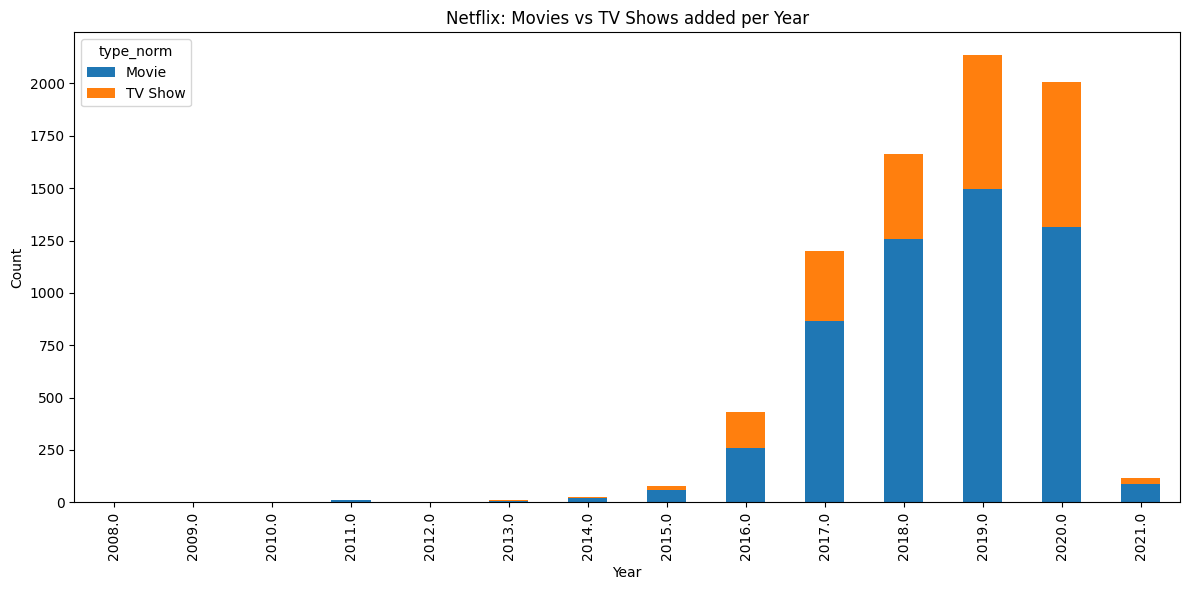

In [16]:
# 📈 Visualizations
os.makedirs("/content/netflix_plots", exist_ok=True)

# Movies vs TV Shows over years
if not by_year_type.empty:
    pivot = by_year_type.pivot(index='year_added', columns='type_norm', values='count').fillna(0)
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12,6))
    ax.set_title("Netflix: Movies vs TV Shows added per Year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig("/content/netflix_plots/movies_tv_by_year.png")
    plt.show()



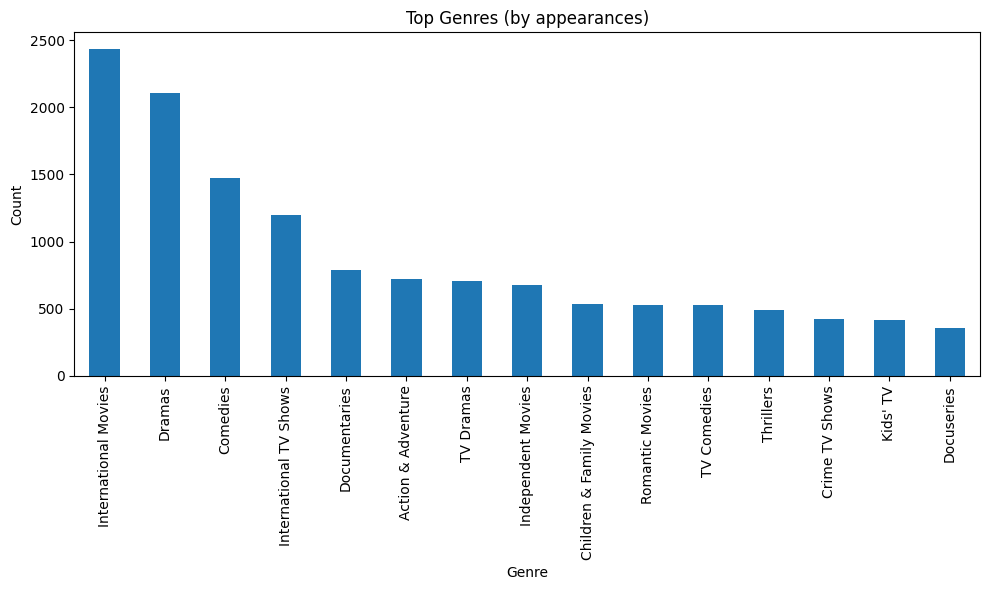

In [17]:


# Top genres bar chart
ax = top_genres.set_index('genre').plot(kind='bar', legend=False, figsize=(10,6))
ax.set_title("Top Genres (by appearances)")
ax.set_xlabel("Genre")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("/content/netflix_plots/top_genres.png")
plt.show()




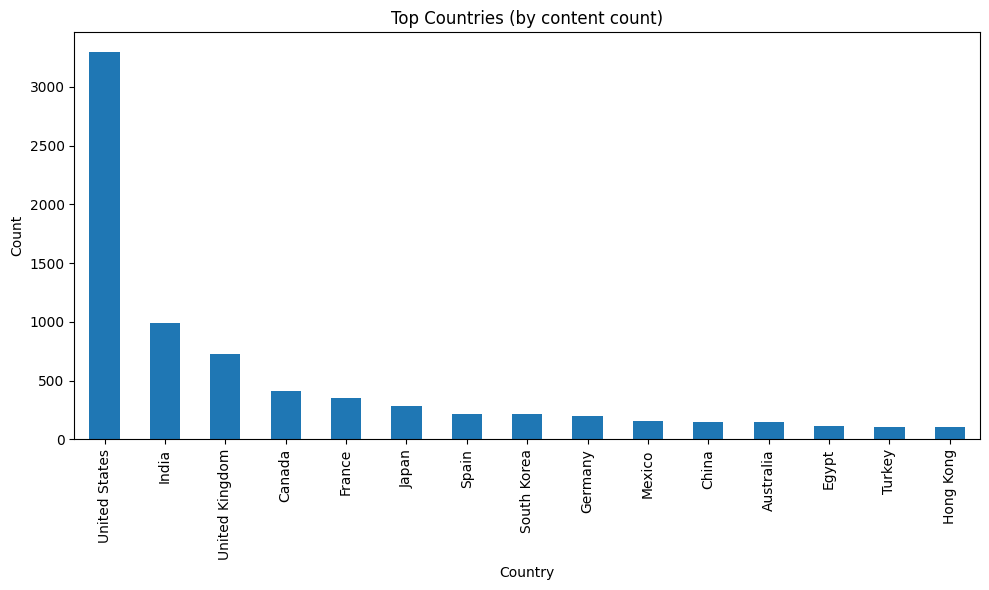

In [19]:

# Top countries bar chart
ax = top_countries.set_index('country').plot(kind='bar', legend=False, figsize=(10,6))
ax.set_title("Top Countries (by content count)")
ax.set_xlabel("Country")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("/content/netflix_plots/top_countries.png")
plt.show()

